In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as plotlib
%matplotlib inline

from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score;
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_friedman1, make_friedman3
from sklearn.utils import check_random_state


from dataclasses import dataclass


# Create Some Helper Classes for Stacking/Combining Models

Simple Averaging Model

In [4]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold


class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models

    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]

        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self

    # Now we do the predictions for cloned models and average them
    def predict(self, X):

        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

Stacking Model using all Models from every Fold

In [5]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)

        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred

        # Now train the cloned  meta-model using the
        # out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    # Do the predictions of all base models on the test data
    # and use the averaged predictions as
    # meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models])
            .mean(axis=1)
            for base_models in self.base_models_])
        return self.meta_model_.predict(meta_features)

Stacking Model using just the first model in the Model list

In [6]:
class StackingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)

        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred

        # Now train the cloned  meta-model using the
        # out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    # Just use One of the Multiple Base model for the 
    # Predictions so no average is needed
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([base_models[0].predict(X)])
            for base_models in self.base_models_])
        return self.meta_model_.predict(meta_features)

In [ ]:
Style Settings for the Plotting

In [7]:
plt.style.use('ggplot')

plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 24, 11
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = True
plt.rcParams['font.serif'] = "cm"




Make some functions to Generate Simulated Data

In [8]:
class Function:
    def  __init__(self,func,string: str):
        self.f=func
        self.s=string
        
    def __call__(self,x):
          return  self.f(x)
        
    def __repr__(self):
        return self.s
    
    def plot(self,ax):
        t = np.arange(-4.0, 4.0, 0.001)
        ax.plot(t, self(t), label=self)
class Function__no_plot:
    def  __init__(self,func,string: str):
        self.f=func
        self.s=string
        
    def __call__(self,x):
          return  self.f(x)
        
    def __repr__(self):
        return self.s
    
    def plot(self,ax):
        t = np.arange(-4.0, 4.0, 0.001)
        ax.plot(t, self(t), label=self,alpha=0,fillstyle='none',marker=None,markerfacecolor='none')
        ax.markersize=2000



        

In [9]:
function_list = [
    Function(lambda x: -2 * (x < -3) + 2.55 * (x > -2) - 2 * (x > 0) + 4 * (x > 2) - 1 * (x > 3),
    "$f_{0}(x)=2.55 \\left(x > -2\\right) - 2 \\left(x > 0\\right) + 4 \\left(x > 2\\right) - \\left(x > 3\\right) - 2 \\left(x < -3\\right)$"),
    Function(lambda x: 0.005*x**3 - 0.36*x**2 + 0.4*x + 6,
    "$f_{1}(x)=0.005 x^{3} - 0.36 x^{2} + 0.4 x + 6$"),
    Function(lambda x: 2.83 * np.sin(np.pi/2 * x),
    "$f_{2}(x)=2.83 \\sin{\\left (\\frac{\\pi x}{2} \\right )}$"),
    Function(lambda x: 4.0 * np.sin(3 * np.pi * x) * (x >= 0),
    "$f_{3}(x)=4.0 \\sin{\\left (3 \\pi x \\right )} \\left(x \\geq 0\\right)$"),
    Function(lambda x: x, 
    "$f_{4}(x)=x$"),
   Function__no_plot( lambda x: np.random.normal(-1, 1,x.shape),
    "$f_{5}(x) = random.normal(-1, 1)$")
]


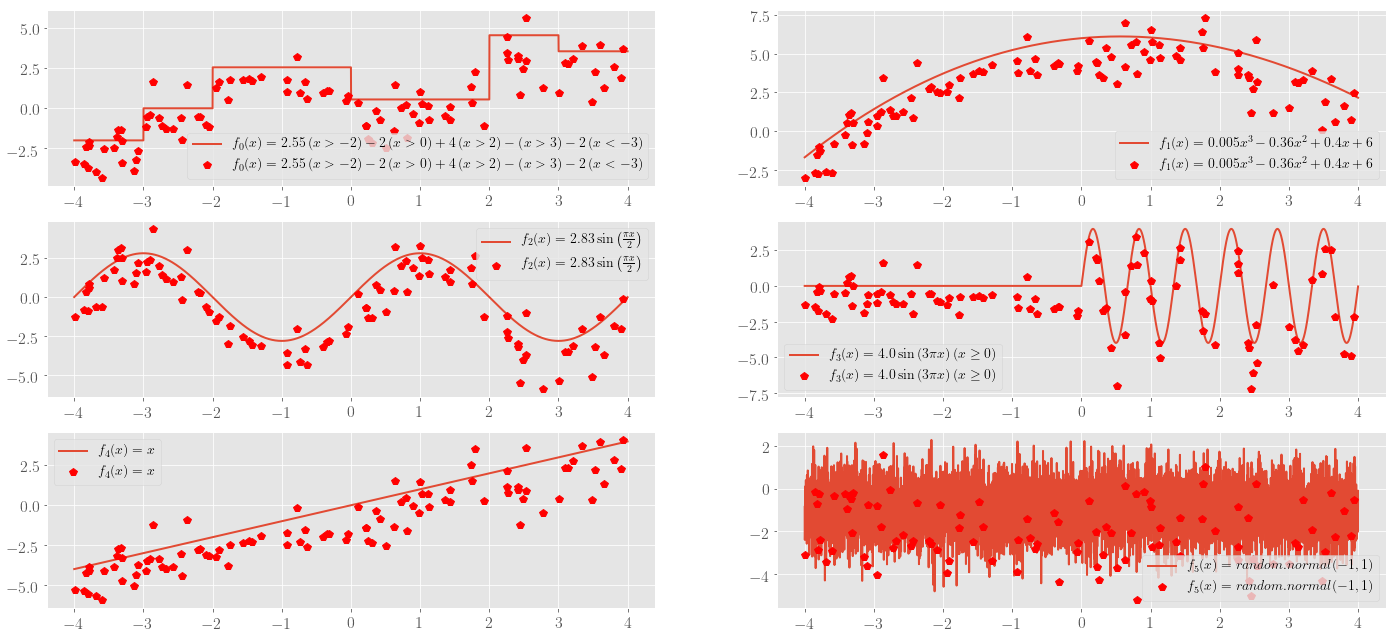

In [10]:
x = np.random.uniform(-4, 4, 100) 
t = np.arange(-4.0, 4.0, 0.001)
err = np.random.normal(-1,1, 100)
fig, axes = plt.subplots(ncols=2, nrows=(len(function_list)+1)//2)
fig.set_size_inches(24,11)
for ax,func in zip(axes.flatten(), function_list):
    yt = func(t)
    yerr = func(x) + err
    ax.plot(t,yt,x,yerr,'rp',label=func)
    
   # ax.scatter(x,yerr)
    ax.legend()
    


Generate the Training data

In [11]:
number_of_samples=100
range_of_x_numbers=(-4,4)
extended_range_of_x_numbers=(-6,6)
error_range=(-1,1)


err = np.random.normal(*error_range, (number_of_samples))
X = np.random.uniform(*range_of_x_numbers, (number_of_samples,1))


@dataclass
class FunctionData:
    function: Function
    X: np.ndarray
    y: np.ndarray

#datalist = np.array([(X,func(X)+err) for func in function_list])


generator = check_random_state(42)

#X = generator.rand(number_of_samples, 1)
#y = 10 * np.sin(np.pi * X[:, 0] * X[:, 1]) + 20 * (X[:, 2] - 0.5) ** 2 \
#    + 10 * X[:, 3] + 5 * X[:, 4] + noise * generator.randn(number_of_samples)


functionDatalist = np.array([FunctionData(func,X,func(X[:,0])+err) for func in function_list])




In [12]:
for fd in functionDatalist:
    print(fd.y.shape,fd.X.shape)

(100,) (100, 1)
(100,) (100, 1)
(100,) (100, 1)
(100,) (100, 1)
(100,) (100, 1)
(100,) (100, 1)


**Define a cross validation strategy**

We use the **cross_val_score** function of Sklearn. However this function has not a shuffle attribut, we add then one line of code, in order to shuffle the dataset prior to cross-validation


In [13]:
n_folds =  5

def rmsle_cv(model,X,y):
    kf = KFold(n_folds, shuffle=True, random_state=1993).get_n_splits(X)
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)
             
    
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

# Create Some Models for the Stacking 

This model may be very sensitive to outliters. So wee need to make it more robost on them.
we use for that sklearns Robustscaler() method on pipleine

In [14]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))

Elastic Net Regression:

In [15]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

Kernel Ridge Regression

In [16]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial',degree=2, coef0=2.5)

Gradient Boosting Regression
with huber loss that makes it robutst to outlies

In [17]:
#GBoost = GradientBoostingRegressor(n_estimators=3000,learning_rate=0.05,max_depth=4,max_features='sqrt',min_samples_leaf=15,min_samples_split=10,loss='huber',random_state=5)

Random Forest Regression

In [18]:
RandomForest = RandomForestRegressor(n_estimators=10)

GuassianProcess

In [19]:
GaussianProcess = GaussianProcessRegressor()

Some Helper Functions for plotting

In [20]:
def train_and_plot_predictions(model,ax,X,y,func):
        model.fit(X,y)
        t = np.arange(-4.0, 4.0, 0.001).reshape(-1, 1)
        ax.plot(t, model.predict(t),'o' ,label=func)
    
def plot_realValues(ax,X,y,func):
        t = np.arange(-4.0, 4.0, 0.01)
        ft = func(t)
        color=next(ax._get_lines.prop_cycler)['color']
        ax.plot(t,ft,X, y,'p', c=color ,alpha=0.8,label=func)
        ax.legend()
        
def plot_side_by_side(model):
    fig, ax =plt.subplots(ncols=2, nrows=1)
    t=np.arange(*range_of_x_numbers,0.01)
    for axe in ax:
        axe.set_ylim(-7.5,7.5)
        axe.set_ylim(-7.5,7.5)
    for fd in functionDatalist:
        train_and_plot_predictions(model,ax[0],fd.X,fd.y,fd.function)
        plot_realValues(ax[1],fd.X,fd.y,fd.function)
    

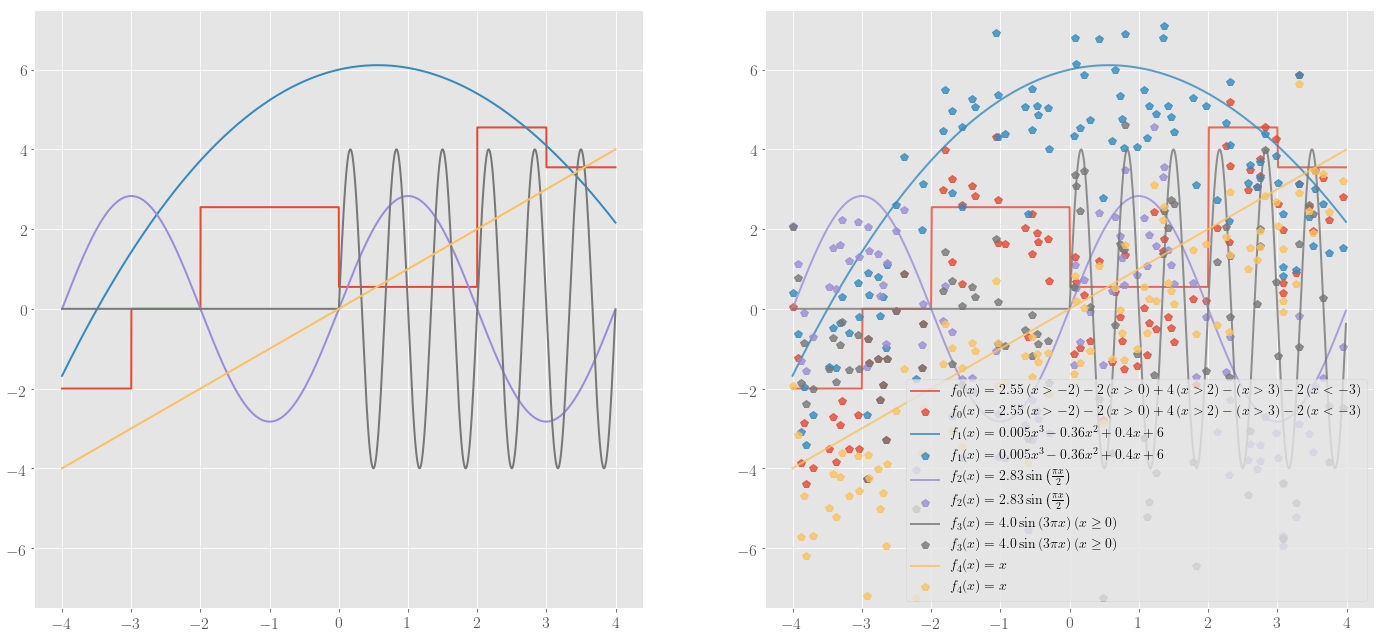

In [21]:


from itertools import cycle

fig, ax =plt.subplots(ncols=2, nrows=1)
plt.scatter
for axe in ax:
        axe.set_ylim(-7.5,7.5)
        axe.set_ylim(-7.5,7.5)

        
for datafunc in functionDatalist[:-1]:
        datafunc.function.plot(ax[0])
        plot_realValues(ax[1],datafunc.X,datafunc.y,datafunc.function)
#print(datalist[0][0].shape)
#plot_realValues(ax[1],datalist[0][0],datalist[0][1])


#plot_noiseValues(ax[0])

[1.9310477  1.84055208 1.64820092 1.33162274 1.45525689]
[1.87473878 1.93436335 1.67773205 1.54422734 1.64110933]
[1.92206058 1.80315189 1.8097855  1.4861224  1.4036491 ]
[2.3103495  2.49602655 2.11898051 1.88092182 1.65544056]
[1.73211962 1.80173906 1.65766044 1.40034849 1.50954289]
[3.0270324  2.16843459 1.72007926 2.16561295 2.30429382]
rmsle    	 0.655566392655935
r^2 score	 0.9290208200700649
rmsle    	 0.59751371106708
r^2 score	 0.9460761254117395
rmsle    	 0.657275812726365
r^2 score	 0.9217041975395346
rmsle    	 0.767353727796719
r^2 score	 0.9036007283910084
rmsle    	 0.6061103925858531
r^2 score	 0.9499937154271525
rmsle    	 0.7858566979757229
r^2 score	 0.7921419598587021


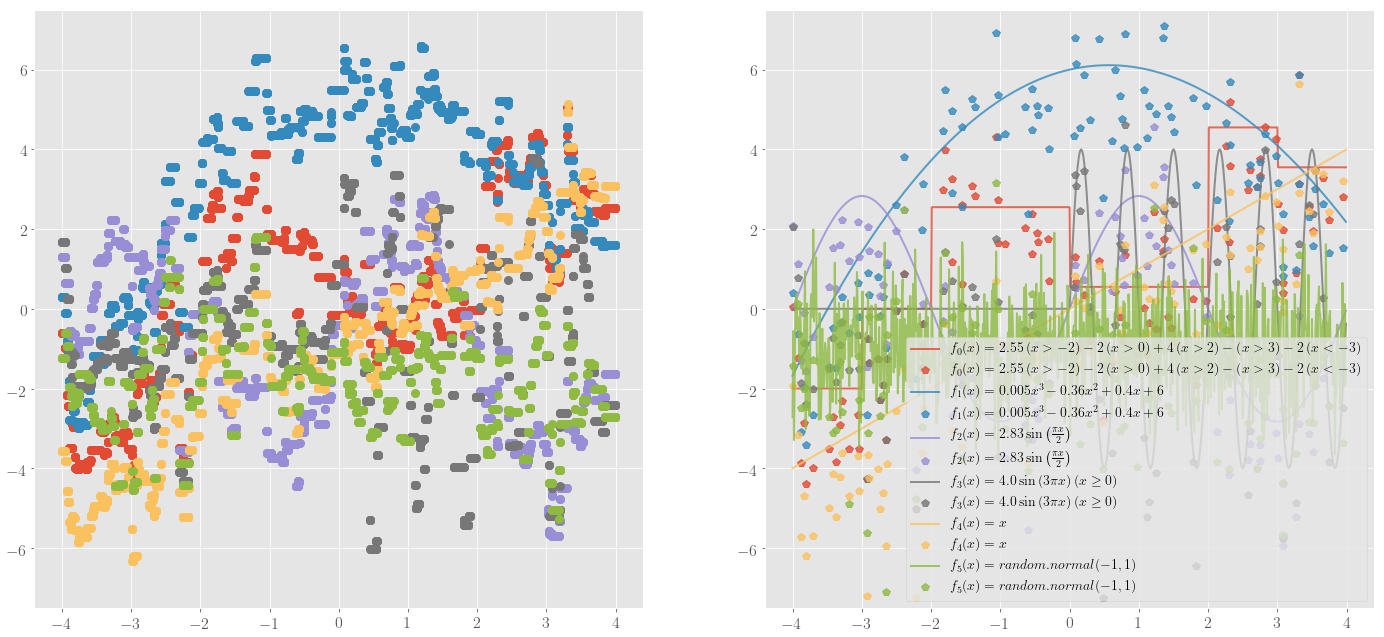

In [22]:

for fd in functionDatalist:
    result = np.array(rmsle_cv(RandomForest,fd.X,fd.y))
    print(result)
    
for fd in functionDatalist:
    RandomForest.fit(fd.X,fd.y)
    print("rmsle    \t",rmsle(fd.y, RandomForest.predict(fd.X)))
    print("r^2 score\t",r2_score(fd.y,RandomForest.predict(fd.X)))
    
plot_side_by_side(RandomForest)

    

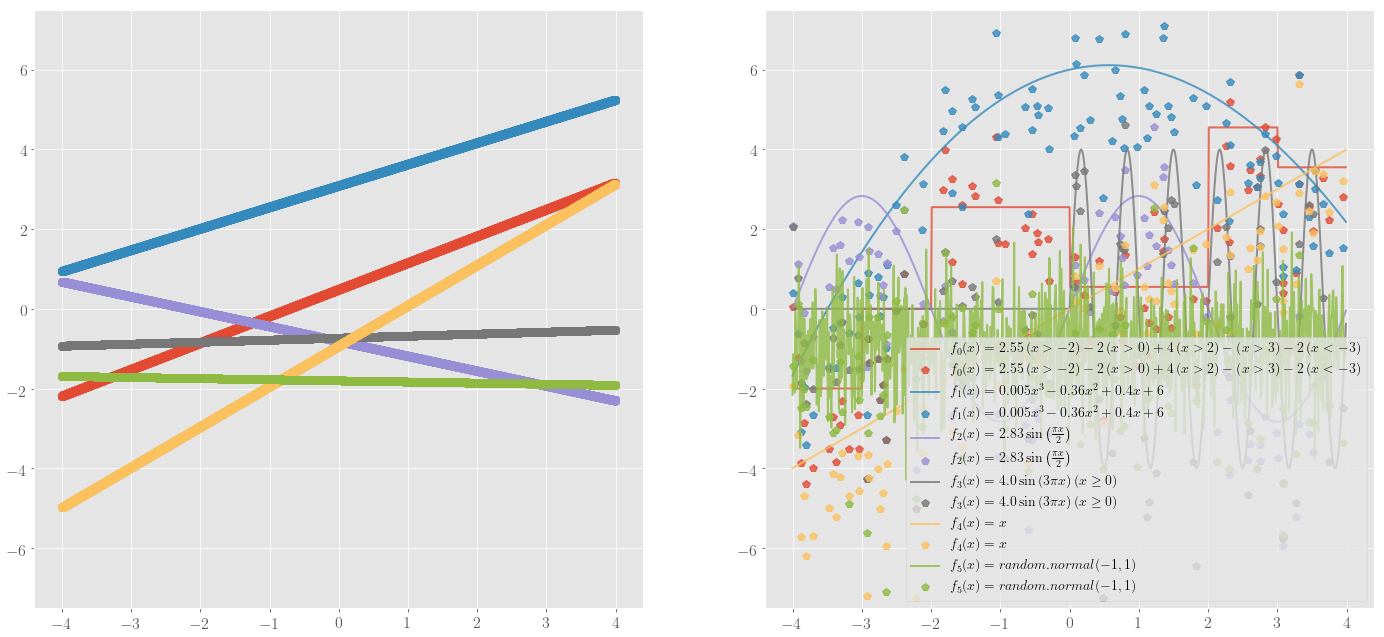

In [23]:
plot_side_by_side(ENet)

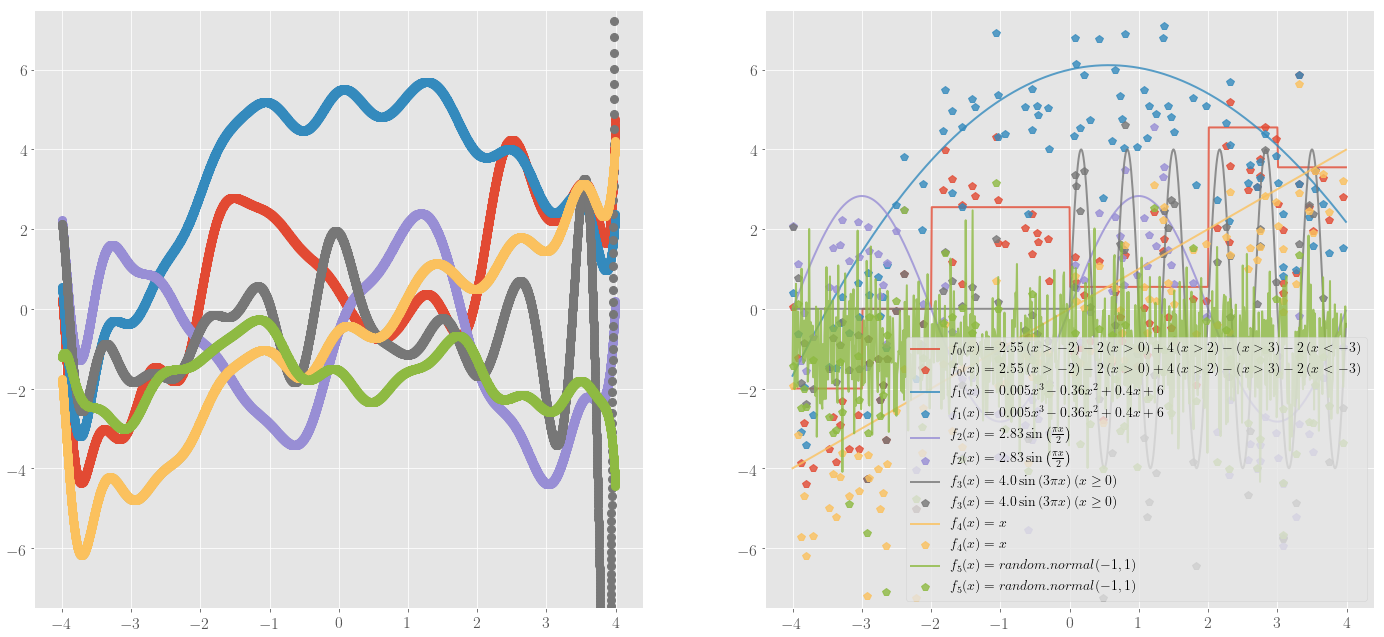

In [24]:
plot_side_by_side(GaussianProcess)

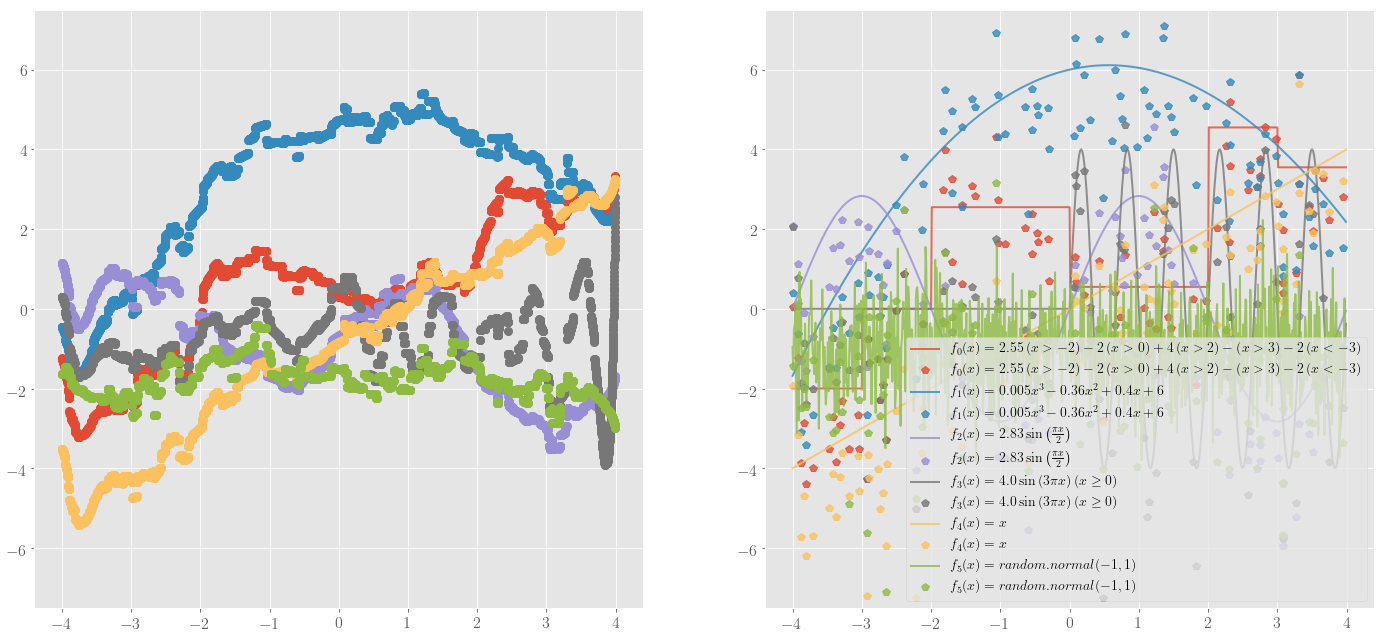

In [25]:
averaging = AveragingModels(models=(GaussianProcess,RandomForest,ENet,KRR))
plot_side_by_side(AveragingModels(models=(GaussianProcess,RandomForest,ENet,KRR)))

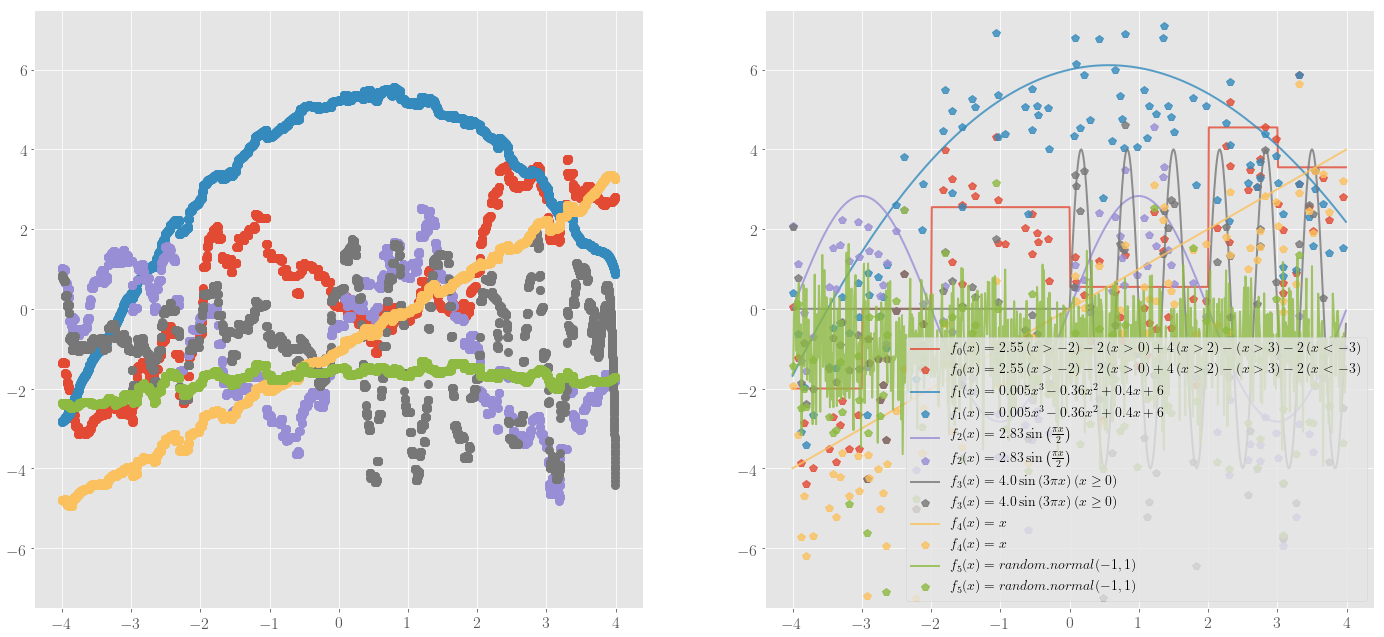

In [26]:


stacked_regression_model = StackingAveragedModels(base_models=(GaussianProcessRegressor(),RandomForestRegressor(n_estimators=10),ENet,KRR),meta_model=(LinearRegression()))
plot_side_by_side(stacked_regression_model)


In [27]:
reg = stacked_regression_model.meta_model_
#reg = LinearRegression()
print(reg.intercept_)   # frage ist dies vielleicht ein Denkfehler weil dies keine gewichtung für die Linare funktion ist.
print(reg.coef_)  # the weights for the regressors


-6.391105186254002
[-0.06079527  0.1274558  -3.22901554  0.59520445]


# Test the Stacking with just using one version of the base_models

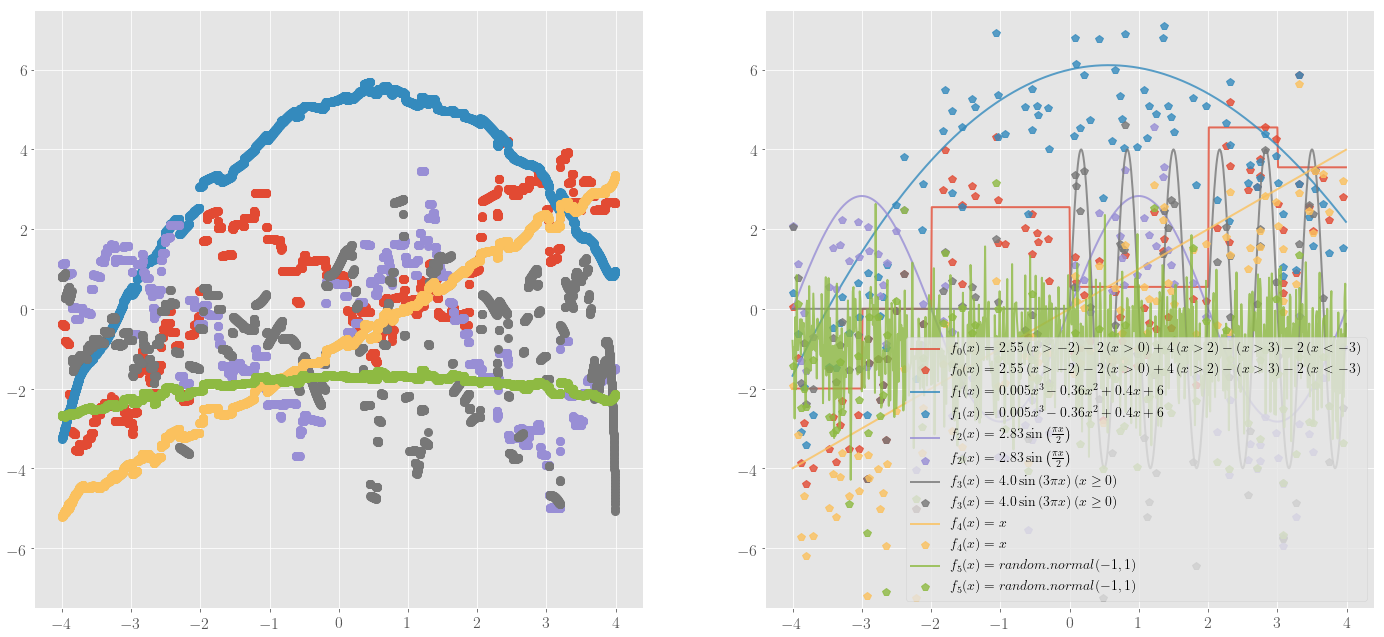

In [28]:

stacked_regression_model = StackingModels(base_models=(GaussianProcessRegressor(),RandomForestRegressor(n_estimators=10),ENet,KRR),meta_model=(LinearRegression()))
plot_side_by_side(stacked_regression_model)